In [1]:
import fastai

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from fastai.tabular.all import *

print("Fastai version:", fastai.__version__)

Fastai version: 2.7.16


In [2]:
# DATA_PATH = '/kaggle/input/titanic'
DATA_PATH = './input'

import os
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input\gender_submission.csv
./input\test.csv
./input\train.csv


In [3]:
train_filename = os.path.join(DATA_PATH, 'train.csv')

train_data = pd.read_csv(train_filename)
print(train_data.shape)
print(train_data.head())

(891, 12)
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.05

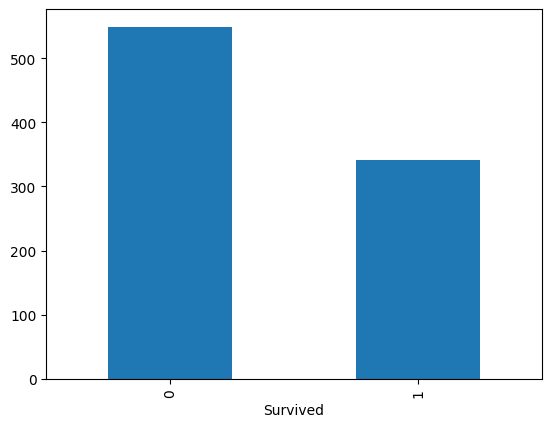

Survived
0    549
1    342
Name: count, dtype: int64


In [4]:
train_data['Survived'].value_counts().plot(kind='bar')
plt.show()

print(train_data['Survived'].value_counts())

In [5]:
print("% Null distribution")
print((train_data.isnull().sum()*100/train_data.shape[0]).sort_values(ascending=False))

print()

print("Number of null values")
print(train_data.isnull().sum().sort_values(ascending=False))

% Null distribution
Cabin          77.104377
Age            19.865320
Embarked        0.224467
PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
dtype: float64

Number of null values
Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64


Type of each column
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Number of unique values
PassengerId    891
Name           891
Ticket         681
Fare           248
Cabin          147
Age             88
SibSp            7
Parch            7
Pclass           3
Embarked         3
Survived         2
Sex              2
dtype: int64


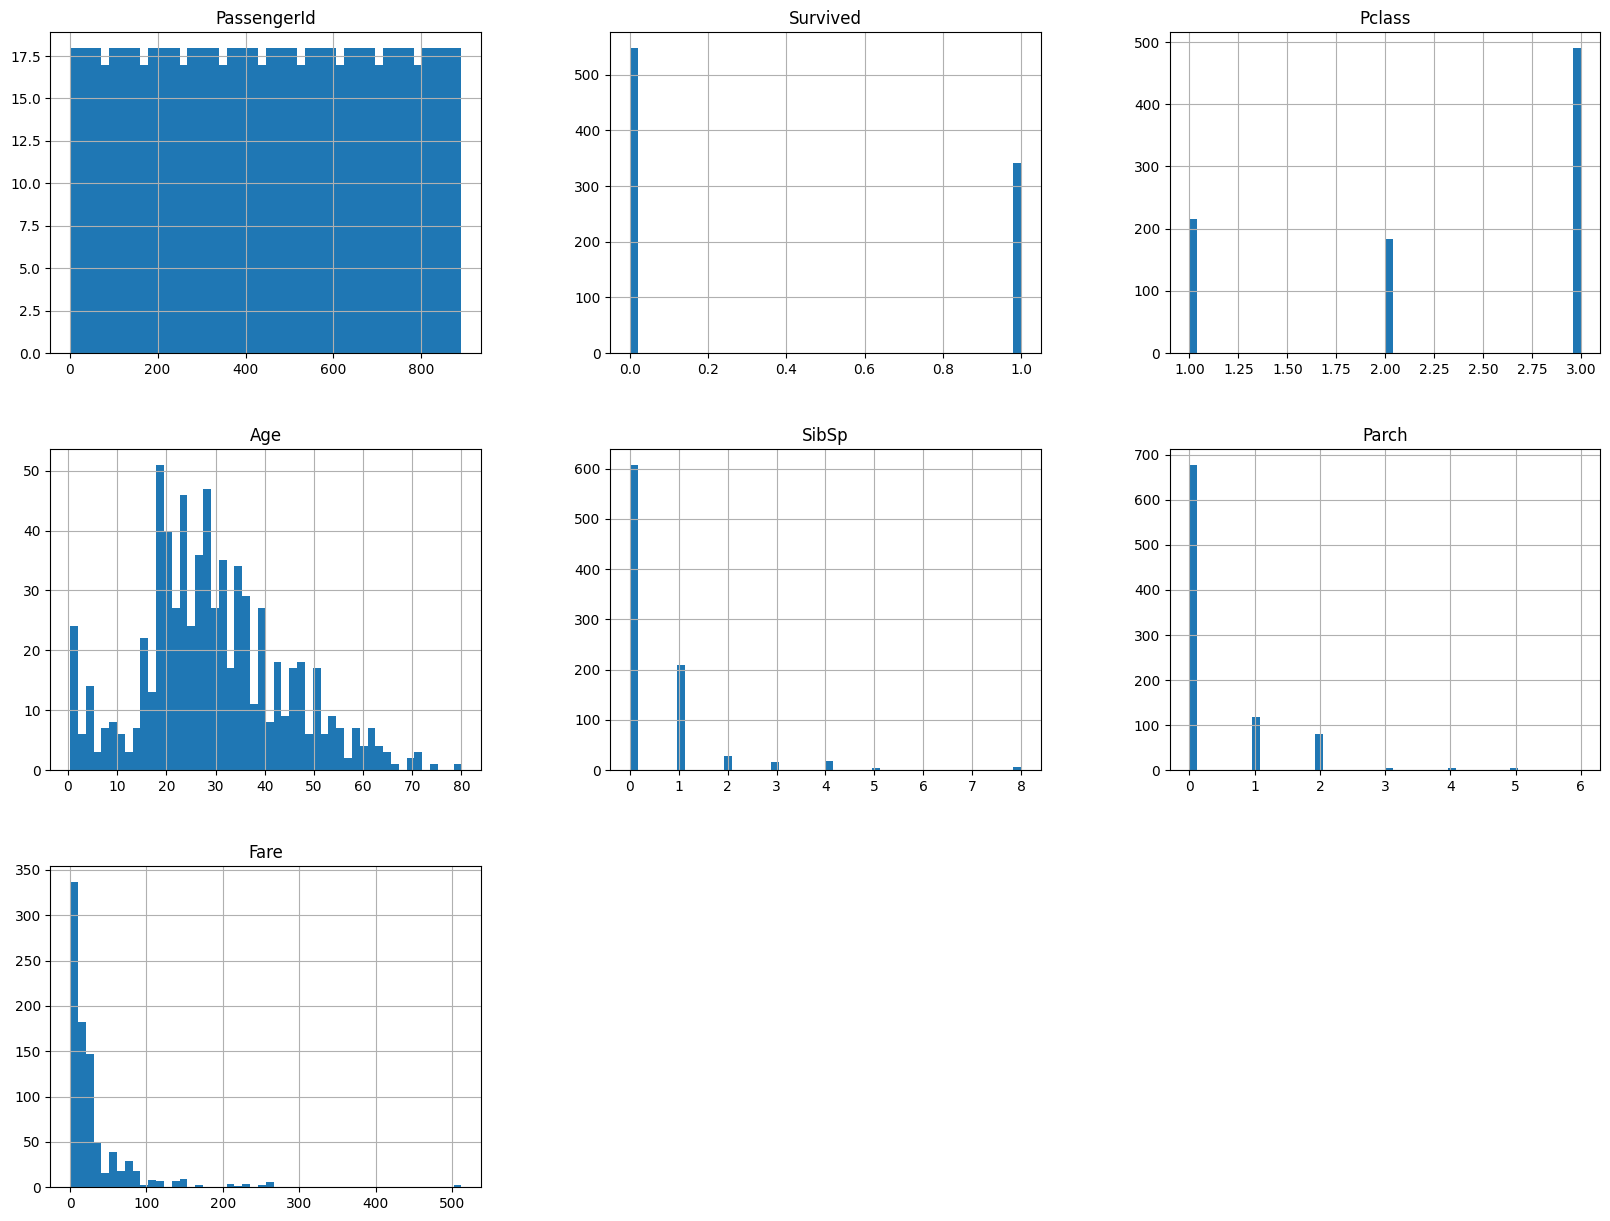

In [6]:
# Get the type of each column
print("Type of each column")
print(train_data.dtypes)

# Get the unique values of each column
print("Number of unique values")
print(train_data.nunique().sort_values(ascending=False))

train_data.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
test_filename = os.path.join(DATA_PATH, 'test.csv')

test_data = pd.read_csv(test_filename)
print(test_data.shape)
print(test_data.head())

(418, 11)
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S  


In [8]:
print("% Null distribution")
print((test_data.isnull().sum()*100/test_data.shape[0]).sort_values(ascending=False))

print()

print("Number of null values")
print(test_data.isnull().sum().sort_values(ascending=False))

% Null distribution
Cabin          78.229665
Age            20.574163
Fare            0.239234
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Embarked        0.000000
dtype: float64

Number of null values
Cabin          327
Age             86
Fare             1
PassengerId      0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Embarked         0
dtype: int64


PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


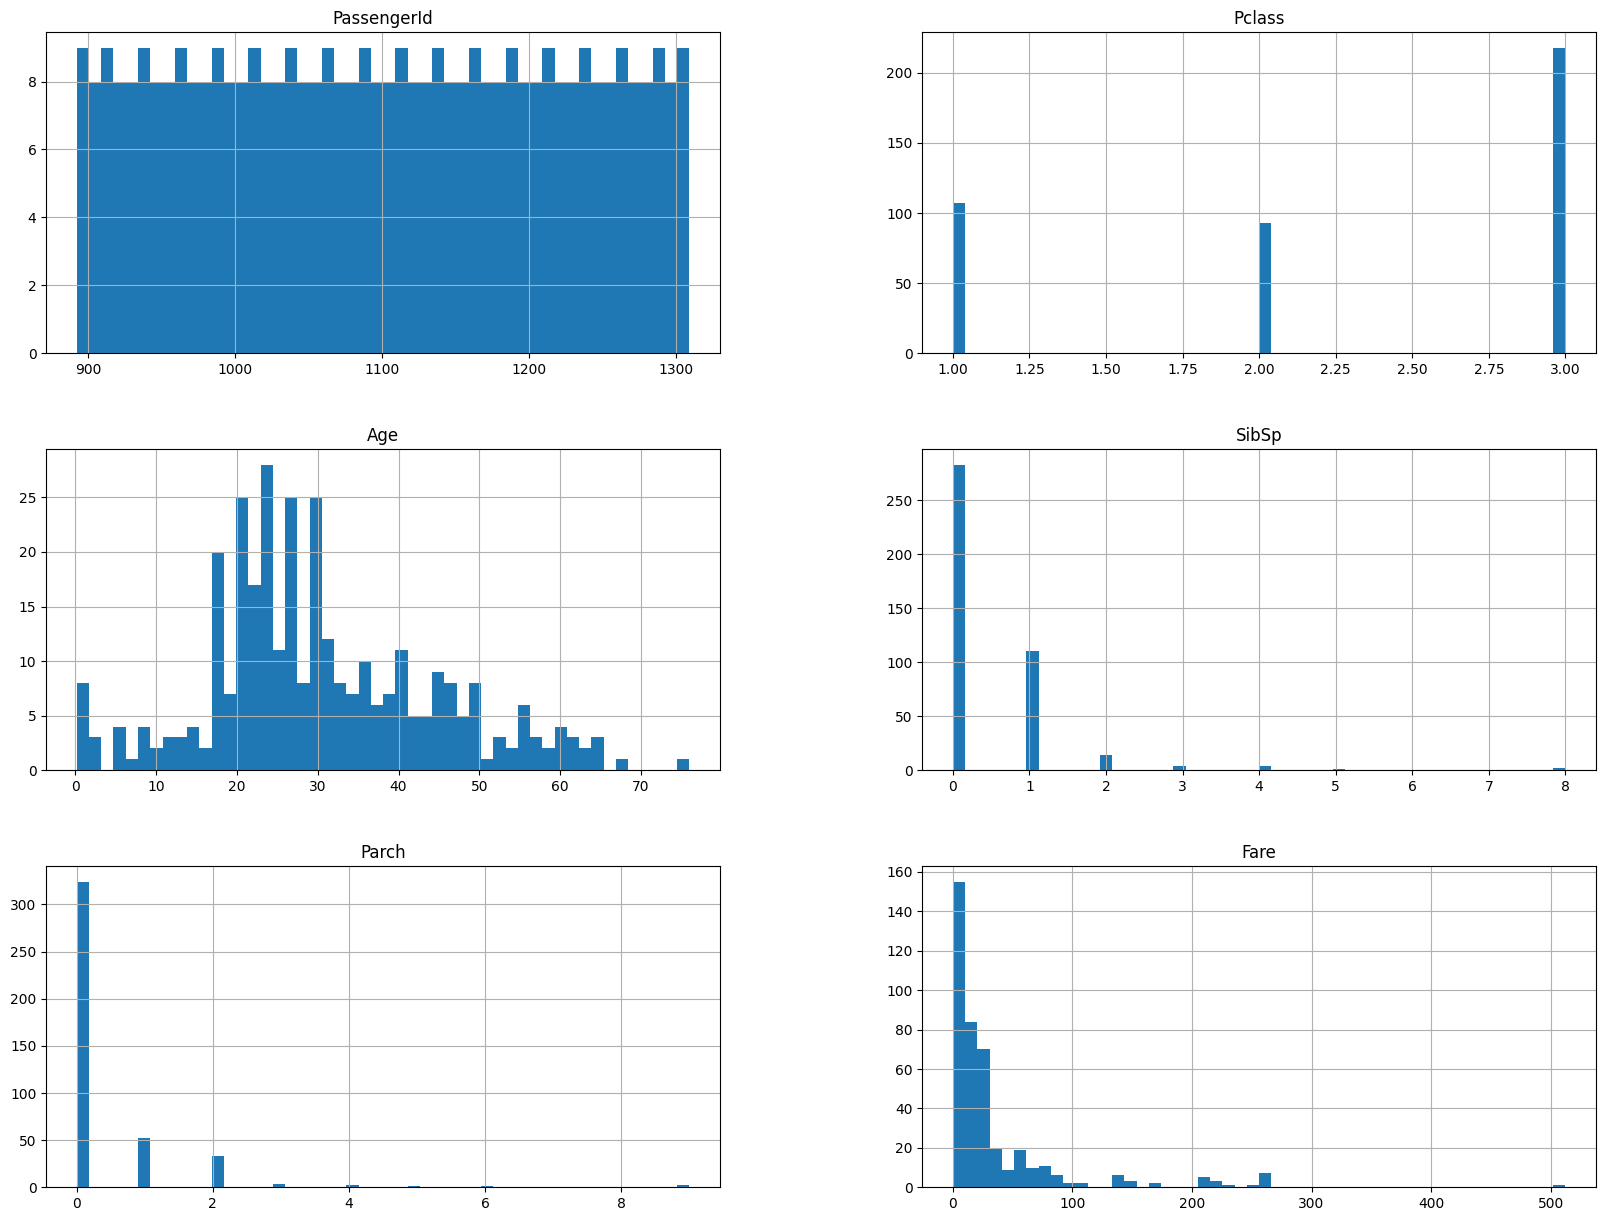

In [9]:
# Get the type of each column
print(test_data.dtypes)

test_data.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
# Remove the unnecessary columns
req_cols = train_data.columns.difference(['PassengerId', 'Name']).tolist()

print("Columns used for training")
print(req_cols)

Columns used for training
['Age', 'Cabin', 'Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket']


In [11]:
# Filter out columns for both training and test data
train_data_filtered = train_data[req_cols]
test_data_filtered = test_data[[cols for cols in req_cols if cols != 'Survived']]

In [12]:
# Split into categorical and continuous variables
cat_vars = ['Pclass', 'SibSp', 'Parch', 'Embarked','Sex', 'Ticket', 'Cabin']
cont_vars = train_data_filtered.columns.difference(cat_vars + ['Survived']).tolist()

print("Categorical variables")
print(cat_vars)

print("Continuous variables")
print(cont_vars)

Categorical variables
['Pclass', 'SibSp', 'Parch', 'Embarked', 'Sex', 'Ticket', 'Cabin']
Continuous variables
['Age', 'Fare']


In [13]:
# Split into training and validation set
splits = RandomSplitter(valid_pct=0.2)(range_of(train_data_filtered))

# Train an intial model using all the columns in the dataset with fastai
tp = TabularPandas(train_data_filtered,
                   procs=[Categorify, FillMissing, Normalize], 
                   cat_names=cat_vars, 
                   cont_names=cont_vars,
                   y_names='Survived',
                   y_block=CategoryBlock(), # To specify single-label classification instead of regression
                   splits=splits)

dls = tp.dataloaders(bs=128)

In [14]:
# Check if the data is loaded correctly
dls.show_batch()

,Pclass,SibSp,Parch,Embarked,Sex,Ticket,Cabin,Age_na,Age,Fare,Survived
0,3,1,1,Q,male,364849,#na#,False,40.000000,15.500000,0
1,3,1,1,S,male,C.A. 37671,#na#,False,3.000000,15.899999,1
2,1,1,1,C,female,PC 17756,E49,False,39.000000,83.158302,1
3,3,0,0,S,female,7552,#na#,False,22.000000,10.516700,0
4,3,0,0,C,female,2687,#na#,False,13.000000,7.229200,1
5,3,2,1,C,female,2666,#na#,False,0.750002,19.258300,1
6,1,0,0,S,male,110465,C110,False,47.000000,52.000000,0
7,1,1,2,S,male,113781,C22 C26,False,0.920001,151.549997,1
8,3,4,2,S,female,347082,#na#,False,9.000000,31.275000,0
9,3,0,0,S,male,349228,#na#,False,19.000000,10.170800,0


In [15]:
print("Label encoding for categorical data \n")
label_encoding_dict = {cat : tp.procs.categorify[cat].o2i for cat in tp.cat_names}
for cat, encoding in label_encoding_dict.items():
    print(f"{cat} : {encoding}")

Label encoding for categorical data 

Pclass : defaultdict(<class 'int'>, {'#na#': 0, 1: 1, 2: 2, 3: 3})
SibSp : defaultdict(<class 'int'>, {'#na#': 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 8: 7})
Parch : defaultdict(<class 'int'>, {'#na#': 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7})
Embarked : defaultdict(<class 'int'>, {'#na#': 0, 'C': 1, 'Q': 2, 'S': 3})
Sex : defaultdict(<class 'int'>, {'#na#': 0, 'female': 1, 'male': 2})
Ticket : defaultdict(<class 'int'>, {'#na#': 0, '110152': 1, '110413': 2, '110465': 3, '110564': 4, '110813': 5, '111240': 6, '111320': 7, '111361': 8, '111369': 9, '111426': 10, '111427': 11, '111428': 12, '112050': 13, '112052': 14, '112053': 15, '112058': 16, '112059': 17, '112277': 18, '112379': 19, '113028': 20, '113043': 21, '113050': 22, '113051': 23, '113055': 24, '113056': 25, '113059': 26, '113501': 27, '113503': 28, '113505': 29, '113509': 30, '113510': 31, '113514': 32, '113572': 33, '113760': 34, '113767': 35, '113773': 36, '113776': 37, '113781': 38,

In [16]:
# Build the NN with 2 layer - [10, 5 Neurons]
learn = tabular_learner(dls,
                        layers=[10,5],
                        metrics=[accuracy, error_rate, Recall(), Precision()])

In [17]:
# Observe model architecture
learn.summary()

TabularModel (Input shape: 128 x 8)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 3             
Embedding                                 12         True      
____________________________________________________________________________
                     128 x 5             
Embedding                                 40         True      
Embedding                                 40         True      
____________________________________________________________________________
                     128 x 3             
Embedding                                 12         True      
Embedding                                 9          True      
____________________________________________________________________________
                     128 x 62            
Embedding                                 42284      True      
____________________________________________________________________________
                     128 x 26           

In [18]:
print("Embedding sizes")
print(learn.embeds)

Embedding sizes
ModuleList(
  (0): Embedding(4, 3)
  (1-2): 2 x Embedding(8, 5)
  (3): Embedding(4, 3)
  (4): Embedding(3, 3)
  (5): Embedding(682, 62)
  (6): Embedding(148, 26)
  (7): Embedding(3, 3)
)


c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\fastai\learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_loc

SuggestedLRs(slide=0.2089296132326126, valley=0.007585775572806597)

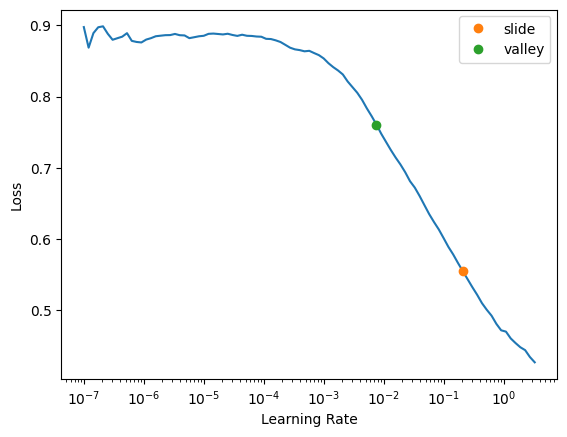

In [19]:
learn.lr_find(suggest_funcs=(slide, valley))

In [20]:
learn.fit_one_cycle(10, lr_max=5e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,time
0,0.841964,0.675716,0.713483,0.286517,0.000000,0.000000,00:00
1,0.774761,0.649137,0.713483,0.286517,0.000000,0.000000,00:00
2,0.671471,0.622032,0.713483,0.286517,0.000000,0.000000,00:00
3,0.579798,0.593255,0.713483,0.286517,0.000000,0.000000,00:00
4,0.515308,0.571457,0.713483,0.286517,0.000000,0.000000,00:00
5,0.459446,0.542149,0.730337,0.269663,0.058824,1.000000,00:00
6,0.409029,0.513293,0.769663,0.230337,0.235294,0.857143,00:00
7,0.367962,0.489111,0.797753,0.202247,0.352941,0.857143,00:00
8,0.335279,0.473398,0.792135,0.207865,0.431373,0.733333,00:00
9,0.309037,0.464520,0.792135,0.207865,0.549020,0.666667,00:00


c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jared\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jared\AppData\Local

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

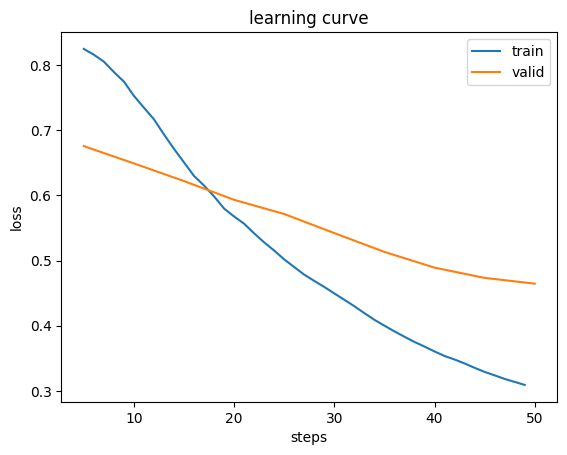

In [21]:
learn.recorder.plot_loss()

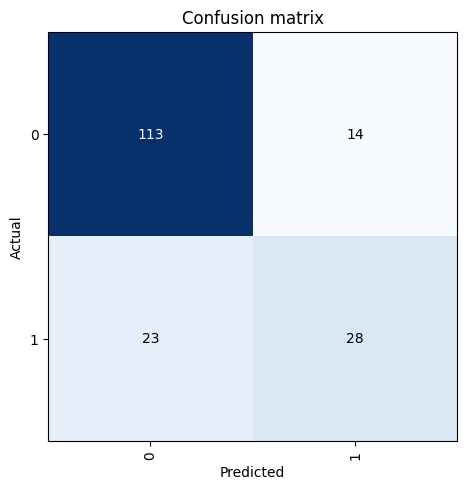

In [22]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

In [23]:
interpret.print_classification_report()

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       127
           1       0.67      0.55      0.60        51

    accuracy                           0.79       178
   macro avg       0.75      0.72      0.73       178
weighted avg       0.78      0.79      0.79       178



In [27]:
# Data preprocessing for missing 'Fare' value in test set
fare_median = test_data_filtered['Fare'].median()
test_data_filtered.loc[:, 'Fare'].fillna(fare_median)

0        7.8292
1        7.0000
2        9.6875
3        8.6625
4       12.2875
         ...   
413      8.0500
414    108.9000
415      7.2500
416      8.0500
417     22.3583
Name: Fare, Length: 418, dtype: float64

In [36]:
test_dl = learn.dls.test_dl(test_data_filtered)
test_dl.process()

preds = learn.get_preds(dl=test_dl)[0].argmax(dim=1).numpy()

In [39]:
output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': preds})
output.to_csv('submission.csv', index=False)
output.head()

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1


In [ ]:
preds